## Aproximate Nearest Neighbor from Scratch

In [ ]:
Note : 
1. Create distance calculation : cosine, eucledian, dot_product
2. Register data into tree object

In [20]:
import numpy as np
import matplotlib.pyplot as plt

In [145]:
class Node:
    def __init__(self,
                 children_left = None,
                 children_right = None,
                 size : int = None,
                 is_leaf : bool = None,
                 hyperplane : np.array = None):
        """Class for store Node

        Args:
            children_left (Tree, optional): 
                Tree for data left. Defaults to None.
            children_right (_type_, optional): 
                Tree for data right. Defaults to None.
            size (int, optional): 
                Count of data point in a tree. Defaults to None.
        """
        self.children_left = children_left
        self.children_right = children_right
        self.size = size
        self.is_leaf = is_leaf
        self.hyperplane = hyperplane


In [146]:
class ApproximateNearestNeighbor:
    def __init__(self,
                 min_sample_per_branch : int = 10):
        self.min_sample_per_branch = min_sample_per_branch

    def create_index(self,
                     X : np.array,
                     y : np.array) -> None :
        # Pass the data by value
        X = np.array(X).copy()
        y = np.array(X).copy()

        # Grow indexing Tree
        self.tree = self.grow_index(X, y)

    def grow_index(self,
                   X : np.array,
                   y : np.array,
                   depth : int = 0):
        # calculate node size
        node_size = len(X)

        # create Tree object
        node = Tree(size = node_size, is_leaf = True)

        # if the node size larger than minimum data
        if node.size > self.min_sample_per_branch:
            # split the node
            X_left, X_right, y_left, y_right, hyperplane = self.hyperplane_split(X, y)
            node.hyperplane = hyperplane
            node.is_leaf = False
            node.children_left = self.grow_index(X_left, y_left, depth+1)
            node.children_right = self.grow_index(X_right, y_right, depth+1)
        return node

    def hyperplane_split(self,
                         X : np.array):

        # pick 2 random data point from data using
        random_index = np.random.randint(low=0, high=len(X)-1, size=2)
        random_point = X[random_index]

        # calculate the middle point
        random_middle = (random_point[0] + random_point[1])/2

        # vector random point
        vector = random_point[0] - random_point[1]

        # Create the hyperplane equation
        a, b = vector
        c = -(a * random_middle[0] + b * random_middle[1])
        hyperplane = np.array([a, b, c])

        # calculate the sign for every data 
        result_sign = np.sign(np.dot(X, hyperplane[:-1].T) + hyperplane[-1])

        # separate the data into left and right data
        X_left = X[np.where(result_sign==-1)]
        X_right = X[np.where(result_sign==1)]
        y_left = y[np.where(result_sign==-1)]
        y_right = y[np.where(result_sign==1)]

        return X_left, X_right, y_left, y_right, hyperplane
        
    def find_similar_item(self,
                          X : np.array,
                          tree = None):
        
        if tree == None:
            tree = self.tree

        if tree.is_leaf:
            ## calculate distance using 
            ## distance equation
            pass
        else:
            sign_check = np.sign(np.dot(X, tree.hyperplane[:-1]) + tree.hyperplane[-1])
            if sign_check == 1:
                branch = tree.children_right
            else:
                branch = tree.children_left
            return self.find_similar_item(X, branch)
        

In [147]:
X = np.random.rand(100,2)
y = np.random.randint(low=100, high=1000, size=100)

print(X.shape, y.shape)

(100, 2) (100,)


In [148]:
model = ApproximateNearestNeighbor(min_sample_per_branch=10)
model.create_index(X, y)

In [153]:
model.tree.hyperplane

array([-0.43780144,  0.23780843,  0.0594893 ])

In [2]:
def hyperplane_split(data : np.array):

    # pick 2 random data point from data using
    random_index = np.random.randint(low=0, high=len(data), size=2)
    random_point = data[random_index]

    # calculate the middle point
    random_middle = (random_point[0] + random_point[1])/2

    # vector random point
    vector = random_point[0] - random_point[1]

    # Create the hyperplane equation
    a, b = vector
    c = -(a * random_middle[0] + b * random_middle[1])

    # calculate the sign for every data 
    result_sign = np.sign(np.dot(data, np.array([a, b]).T) + c)

    # separate the data into left and right data
    data_left = data[np.where(result_sign==1)]
    data_right = data[np.where(result_sign==-1)]

    return data_left, data_right

In [7]:
data = np.random.rand(100,2)
data_1, data_2 = hyperplane_split(data)

data.shape, data_1.shape, data_2.shape

((100, 2), (55, 2), (45, 2))

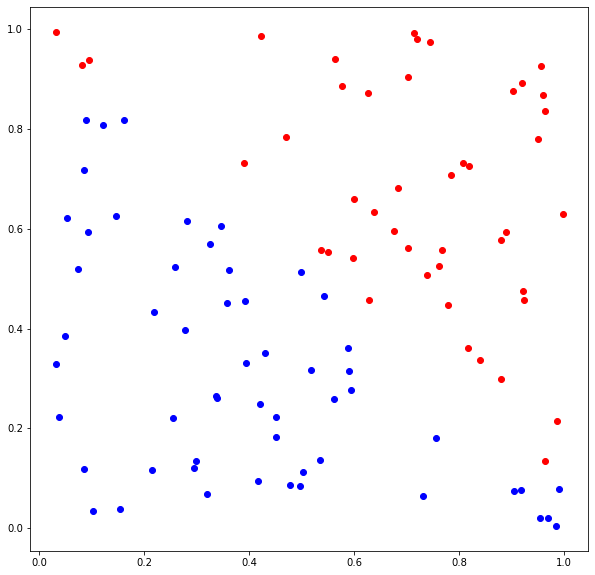

In [8]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(data_1[:,0], data_1[:,1], color="blue")
ax.scatter(data_2[:,0], data_2[:,1], color="red")
plt.show()

In [9]:
data_1_1, data_1_2 = hyperplane_split(data_1)
data_2_1, data_2_2 = hyperplane_split(data_2)

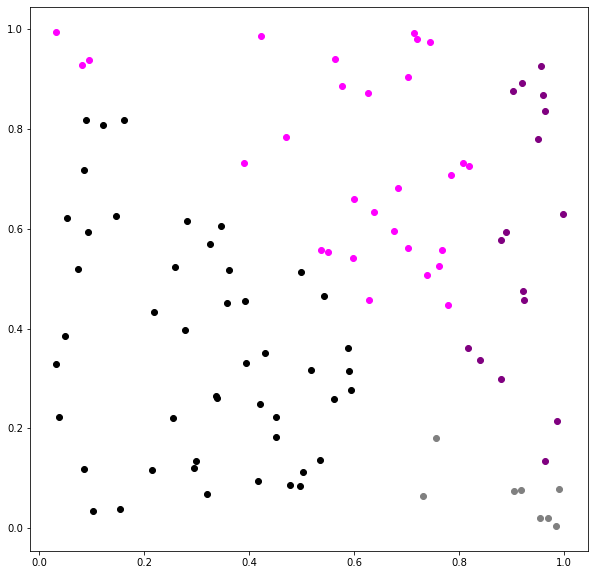

In [10]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(data_1_1[:,0], data_1_1[:,1], color="black")
ax.scatter(data_1_2[:,0], data_1_2[:,1], color="grey")
ax.scatter(data_2_1[:,0], data_2_1[:,1], color="purple")
ax.scatter(data_2_2[:,0], data_2_2[:,1], color="magenta")
plt.show()

(41, 2)
(59, 2)


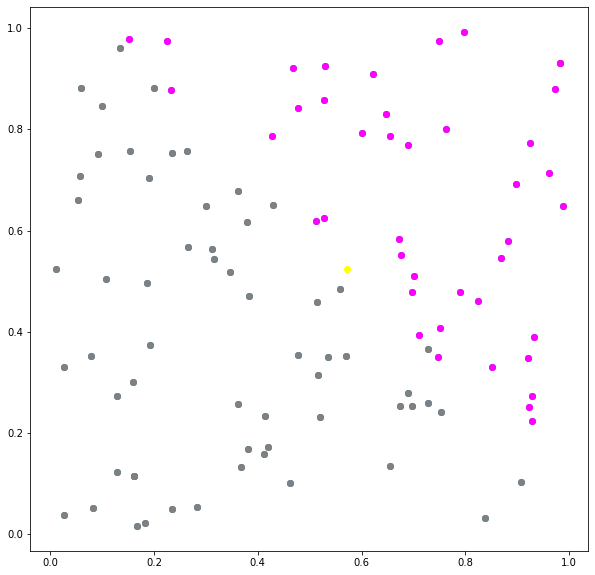

In [160]:
data = np.random.rand(100,2)
fix, ax = plt.subplots(figsize=(10,10))
ax.scatter(data[:,0], data[:,1])

# pick 2 random number from data using index
random_index = np.random.randint(low=0, high=len(data), size=2)
random_data_point = data[random_index]
ax.scatter(random_data_point[:,0], random_data_point[:,1], color="red")

# calculate the middle point
random_data_point_middle = (random_data_point[0] + random_data_point[1])/2
ax.scatter(random_data_point_middle[0], random_data_point_middle[1], color="yellow")

# vector random point
vector = random_data_point[0] - random_data_point[1]

# Create the hyperplane equation
# ax + by + c = 0, where (a, b) is the perpendicular vector, and (x, y) is a point on the hyperplane
a, b = vector
c = -(a * random_data_point_middle[0] + b * random_data_point_middle[1])

# Classify the test points as below or above the hyperplane
data_1 = []
data_2 = []
for d in data:
    result = a * d[0] + b * d[1] + c
    if result > 0:
        data_1.append(d)
        ax.scatter(d[0], d[1], color="magenta")
    else:
        data_2.append(d)
        ax.scatter(d[0], d[1], color="grey")

print(np.array(data_1).shape)
print(np.array(data_2).shape)

In [163]:
np.sign(np.dot(data,np.array([a,b]).T) + c).shape
        

(100,)

In [152]:
np.array(data_2).shape

(54, 2)

In [114]:
np.dot(vector, perpendicular_vector)

0.0

In [70]:
hyperplane = np.array([grad2, c])
hyperplane

array([-0.37126911,  0.37017695])